In [ ]:
import os
import pickle
import numpy as np
from numba import njit
from typing import Callable

from utils.methods import secant, false_position, rk4
from utils.utilities import y_vacuum, get_ODE_function, get_secant_function, get_monotonic_segments

from matplotlib import pyplot as plt
import matplotlib.colors as mcol
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib import ticker as ticker
from matplotlib.ticker import FuncFormatter

from utils.plot import formatter
import utils.plot as plot_utils

textwidth = plot_utils.textwidth
textheight = plot_utils.textheight
inch_per_cm = plot_utils.inch_per_cm
golden_ratio = plot_utils.golden_ratio

In [ ]:
### SPECIFY PARAMETERS

exponent = 0

# runge-Kutta parameters
R_MIN = 1.0
R_MAX = 2000.0
STEP = -0.05

# secant method parameters
SECANT_TOLERANCE = 1e-8
SECANT_MAX_ITERS = 50
SECANT_INITIAL_STEP = 1e-6

# density profile

RADIUS = 500
SIGMA = 25

shell = "gauss"

def get_rho(parameter: float) -> Callable[[float], float]:

    amplitude = parameter
    sigma = SIGMA
    radius = RADIUS

    @njit
    def _rho(x: float) -> float:
            return amplitude * np.exp(-0.5 * (x - radius)**2 / (sigma**2))
    return _rho

In [ ]:
if os.path.isfile("data/" +  shell + "_critical.pkl"):
    with open("data/" +  shell + "_critical.pkl", "rb") as f:
        results = pickle.load(f)

    critical_alpha = results["critical_alpha"]
    critical_parameter = results["critical_parameter"]

In [92]:
# prepare the arrays for results

unscaled_alpha = []
unscaled_r = []

unscaled_psi = []
unscaled_dpsi = []

scaled_alpha = []
scaled_r = []

scaled_psi = []
scaled_dpsi = []

scaled_areal_radii = []
unscaled_areal_radii = []

scaled_proper_radii = []
unscaled_proper_radii = []

unscaled_rest_mass = []
scaled_rest_mass = []

unscaled_ADM_mass = []
scaled_ADM_mass = []

scaled_embedding_z = []
scaled_embedding_areal_r = []

unscaled_embedding_z = []
unscaled_embedding_areal_r = []

scaled_rho_r = []
scaled_rho_r_with_scaling = []
scaled_rho_areal_r = []
scaled_rho_proper_r = []

unscaled_parameters = []
scaled_parameters = []

In [93]:
rho = get_rho(critical_parameter)
alpha_guess = critical_alpha

ode_unscaled = get_ODE_function(rho, exponent=5)
sec_unscaled = get_secant_function(rho, R_MAX, R_MIN, STEP, exponent=5)

root, _, success = secant(sec_unscaled, SECANT_TOLERANCE, SECANT_MAX_ITERS, alpha_guess, SECANT_INITIAL_STEP)
print(_)
print("Unscaled root:", root[-1], "Success:", success)

x, y = rk4(ode_unscaled, R_MAX, y_vacuum(root[-1], R_MAX), R_MIN, STEP)

unscaled_critical_alpha = root[-1]
unscaled_critical_r = np.flip(x)
unscaled_critical_psi = np.flip(y[:, 0])
unscaled_critical_dpsi = np.flip(y[:, 1])

unscaled_critical_areal_radius = [_r * _psi_r**2 for _r, _psi_r in zip(unscaled_critical_r, unscaled_critical_psi)]

unscaled_critical_proper_radius = [0] # proper radius at r = 0 is 0
integral = 0.0
for k in range(1, len(unscaled_critical_r)):
    delta_r_k = unscaled_critical_r[k] - unscaled_critical_r[k - 1]
    integral += 0.5 * (unscaled_critical_psi[k]**2 + unscaled_critical_psi[k - 1]**2) * delta_r_k
    unscaled_critical_proper_radius.append(integral)


25
Unscaled root: 129.38369055549032 Success: True


In [ ]:
# calculate conformal factors and other properties for a range of density amplitudes using false position method

pars = np.linspace(1e-07, 0.97 * critical_parameter, 5) # chosen by hand, to have a good distribution of parameters

for par in pars:
    selected_par = par
    rho = get_rho(selected_par)

    ode_unscaled = get_ODE_function(rho, exponent=5)
    sec_unscaled = get_secant_function(rho, R_MAX, R_MIN, STEP, exponent=5)

    N = 50
    alphas = np.linspace(0, 1000, N)
    root_tol = 1e-12
    max_iters = 20

    sec_unscaled_vals = [sec_unscaled(a) for a in alphas]

    max_iters = 20
    tol = 1e-12


    print(f"parameter = {selected_par:.4g}:")

    for i in range(len(alphas) - 1):
        if sec_unscaled_vals[i] * sec_unscaled_vals[i + 1] < 0:
            # there is a root
            root, _, success = false_position(sec_unscaled, tol, max_iters, alphas[i], alphas[i + 1])
            if success:
                x, y = rk4(ode_unscaled, R_MAX, y_vacuum(root, R_MAX), R_MIN, STEP)
                if root > 0 and np.all(y[:,0] > 0): # M_ADM > 0 and Ψ > 0
                    print(f'[✓] ADM mass ≈ {2*root:.4g}, Ψ(0) ≈ {y[-1][0]:.4g}, Ψ"(0) ≈ {y[-1][1]:.4g} (unscaled)')
                    unscaled_alpha.append(root)
                    unscaled_r.append(np.flip(x))
                    unscaled_psi.append(np.flip(y[:,0]))
                    unscaled_dpsi.append(np.flip(y[:,1]))
                    unscaled_parameters.append(selected_par)
                    unscaled_ADM_mass.append(2 * root)
                    
                elif root < 0:
                    print(f"[✗] converged to negative root in interval [{2*alphas[i]:.4g}, {2*alphas[i + 1]:.4g}] (unscaled)")
                elif np.any(y[:,0] < 0):
                    print(f"[✗] Ψ <= 0 in for root in interval [{2*alphas[i]:.4g}, {2*alphas[i + 1]:.4g}] (unscaled)")


parameter = 1e-07:
[✓] ADM mass ≈ 21.93, Ψ(0) ≈ 1.022, Ψ"(0) ≈ -8.023e-14 (unscaled)
[✓] ADM mass ≈ 1375, Ψ(0) ≈ 2.376, Ψ"(0) ≈ -6.277e-13 (unscaled)
parameter = 1.787e-07:
[✓] ADM mass ≈ 43.33, Ψ(0) ≈ 1.043, Ψ"(0) ≈ -4.04e-13 (unscaled)
[✓] ADM mass ≈ 966.1, Ψ(0) ≈ 1.966, Ψ"(0) ≈ 5.493e-13 (unscaled)
parameter = 2.575e-07:
[✓] ADM mass ≈ 70.83, Ψ(0) ≈ 1.071, Ψ"(0) ≈ -6.437e-13 (unscaled)
[✓] ADM mass ≈ 719.9, Ψ(0) ≈ 1.72, Ψ"(0) ≈ -8.459e-13 (unscaled)
parameter = 3.362e-07:
[✓] ADM mass ≈ 110.3, Ψ(0) ≈ 1.11, Ψ"(0) ≈ 2.505e-13 (unscaled)
[✓] ADM mass ≈ 531.6, Ψ(0) ≈ 1.531, Ψ"(0) ≈ -5.06e-14 (unscaled)
parameter = 4.149e-07:
[✓] ADM mass ≈ 193.8, Ψ(0) ≈ 1.193, Ψ"(0) ≈ -2.088e-13 (unscaled)
[✓] ADM mass ≈ 336.7, Ψ(0) ≈ 1.336, Ψ"(0) ≈ -5.876e-13 (unscaled)


In [ ]:
pars = np.linspace(1e-07, 7e-6, 5) # ad hoc, automated later

for par in pars:
    selected_par = par
    rho = get_rho(selected_par)

    ode_scaled = get_ODE_function(rho, exponent=0)
    sec_scaled = get_secant_function(rho, R_MAX, R_MIN, STEP, exponent=0)

    N = 50
    alphas = np.linspace(0, 1000, N)
    root_tol = 1e-12
    max_iters = 20

    sec_scaled_vals = [sec_scaled(a) for a in alphas]

    max_iters = 20
    tol = 1e-12


    print(f"parameter = {selected_par:.4g}:")

    for i in range(len(alphas) - 1):
        if sec_scaled_vals[i] * sec_scaled_vals[i + 1] < 0:
            # there is a root
            root, _, success = false_position(sec_scaled, tol, max_iters, alphas[i], alphas[i + 1])
            if success:
                x, y = rk4(ode_scaled, R_MAX, y_vacuum(root, R_MAX), R_MIN, STEP)
                if root > 0 and np.all(y[:,0] > 0): # M_ADM > 0 and Ψ > 0
                    print(f'[✓] ADM mass ≈ {2*root:.4g}, Ψ(0) ≈ {y[-1][0]:.4g}, Ψ"(0) ≈ {y[-1][1]:.4g} (scaled)')
                    scaled_alpha.append(root)
                    scaled_r.append(np.flip(x))
                    scaled_psi.append(np.flip(y[:,0]))
                    scaled_dpsi.append(np.flip(y[:,1]))
                    scaled_parameters.append(selected_par)
                    scaled_ADM_mass.append(2 * root)
                elif root < 0:
                    print(f"[✗] converged to negative root in interval [{2*alphas[i]:.4g}, {2*alphas[i + 1]:.4g}](scaled)")
                elif np.any(y[:,0] < 0):
                    print(f"[✗] Ψ <= 0 in for root in interval [{2*alphas[i]:.4g}, {2*alphas[i + 1]:.4g}] (scaled)")
                else:
                    print(f"[✗] unknown error in interval [{2*alphas[i]:.4g}, {2*alphas[i + 1]:.4g}] (scaled)")

    print("\n")


parameter = 1e-07:
[✓] ADM mass ≈ 19.74, Ψ(0) ≈ 1.02, Ψ"(0) ≈ 2.084e-13 (scaled)


parameter = 1.825e-06:
[✓] ADM mass ≈ 360.2, Ψ(0) ≈ 1.359, Ψ"(0) ≈ -7.429e-13 (scaled)


parameter = 3.55e-06:
[✓] ADM mass ≈ 700.6, Ψ(0) ≈ 1.699, Ψ"(0) ≈ 1.79e-13 (scaled)


parameter = 5.275e-06:
[✓] ADM mass ≈ 1041, Ψ(0) ≈ 2.038, Ψ"(0) ≈ -7.274e-13 (scaled)


parameter = 7e-06:
[✓] ADM mass ≈ 1382, Ψ(0) ≈ 2.378, Ψ"(0) ≈ -9.06e-13 (scaled)




In [96]:
# check for apparent horizons

unscaled_horizons = [] # lists with ADM mass, position, position error, Ψ" + Ψ / 2r

for r, psi, dpsi, alpha in zip(unscaled_r, unscaled_psi, unscaled_dpsi, unscaled_alpha):

    _f = [_dpsi + 0.5 * _psi / _r for _r, _psi, _dpsi in zip(r, psi, dpsi)]

    for i in range(1, len(_f)):
        if _f[i - 1] * _f[i] < 0:
            position = (r[i]+r[i-1])/2
            error = abs(r[i]-r[i-1])/2
            _f_err = (_f[i]-_f[i-1])/(r[i]-r[i-1])*((r[i]+r[i-1])/2-r[i-1]) + _f[i-1]  # linear interpolation to find root
        
            unscaled_horizons.append([2*alpha, position, error, _f_err])


scaled_horizons = [] 

for r, psi, dpsi, alpha in zip(scaled_r, scaled_psi, scaled_dpsi, scaled_alpha):

    _f = [_dpsi + 0.5 * _psi / _r for _r, _psi, _dpsi in zip(r, psi, dpsi)]

    for i in range(1, len(_f)):
        if _f[i - 1] * _f[i] < 0:
            position = (r[i]+r[i-1])/2
            error = abs(r[i]-r[i-1])/2
            _f_err = (_f[i]-_f[i-1])/(r[i]-r[i-1])*((r[i]+r[i-1])/2-r[i-1]) + _f[i-1]

            scaled_horizons.append([2*alpha, position, error, _f_err])


print("unscaled \n")
for horizon_info in unscaled_horizons:
    if len(horizon_info) > 0:
        print(f'    ADM mass ≈ {horizon_info[0]:.3f}, app. horizon at r ≈ {horizon_info[1]:.3g}±{horizon_info[2]:.2g}')
        print(f'    ( Ψ" + Ψ / 2r ≈ {horizon_info[3]:.1g})') # linear interpolation

print("\n scaled")
for horizon_info in scaled_horizons:
    if len(horizon_info) > 0:
        print(f"    ADM mass ≈ {horizon_info[0]:.3f}, app. horizon at r ≈ {horizon_info[1]:.3g}±{horizon_info[2]:.2g}")

unscaled 

    ADM mass ≈ 1375.186, app. horizon at r ≈ 530±0.025
    ( Ψ" + Ψ / 2r ≈ -2e-07)
    ADM mass ≈ 1375.186, app. horizon at r ≈ 688±0.025
    ( Ψ" + Ψ / 2r ≈ -2e-08)

 scaled
    ADM mass ≈ 1381.536, app. horizon at r ≈ 532±0.025
    ADM mass ≈ 1381.536, app. horizon at r ≈ 691±0.025


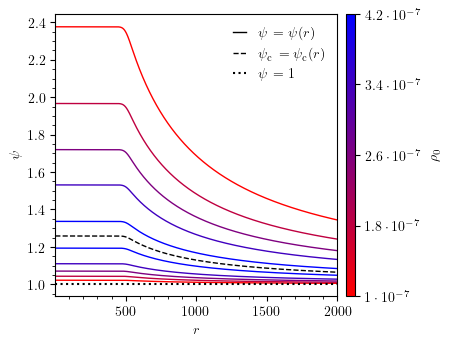

In [ ]:
scale = 0.7
fig_width_inches = textwidth * inch_per_cm * scale
desired_size_inches = fig_width_inches 

left_margin_frac = 0.15  
bottom_margin_frac = 0.15 
top_margin_frac = 0.05   
right_margin_frac = 0.05  

plot_area_width_frac = 1.0 - left_margin_frac - right_margin_frac
plot_area_height_frac = 1.0 - bottom_margin_frac - top_margin_frac

ax_size_frac = min(plot_area_width_frac * 0.8, plot_area_height_frac) 

cbar_width_frac = 0.02
pad_frac = 0.02

ax_left = left_margin_frac
ax_bottom = bottom_margin_frac
ax_width = ax_size_frac
ax_height = ax_size_frac 

cax_left = ax_left + ax_width + pad_frac
cax_bottom = ax_bottom
cax_width = cbar_width_frac
cax_height = ax_height 


fig = plt.figure(figsize=(desired_size_inches, desired_size_inches))
ax = fig.add_axes([ax_left, ax_bottom, ax_width, ax_height])
cax = fig.add_axes([cax_left, cax_bottom, cax_width, cax_height])

norm =  mcol.Normalize(vmin=np.min(unscaled_parameters), vmax=np.max(unscaled_parameters))
cmap = mcol.LinearSegmentedColormap.from_list("rbmap",["r","b"]) 
colors = cmap(norm(unscaled_parameters))

i = 0
for _r, _psi, in zip(unscaled_r, unscaled_psi):
    if i == 0:
        ax.plot(_r, _psi, color=colors[i], alpha=1, linewidth=1, label=r"$\psi\, = \psi(r)$")
    else:
        ax.plot(_r, _psi, color=colors[i], alpha=1, linewidth=1)
    i += 1

sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([]) 

cbar = fig.colorbar(sm, cax=cax, orientation="vertical")

cbar.set_label(r"$\rho_0$", fontsize=10, labelpad=5)

tick_vals = np.linspace(unscaled_parameters[0], unscaled_parameters[-1], 5) 

#[unscaled_parameters[0], np.mean(unscaled_parameters), unscaled_parameters[-1]]
cbar.set_ticks(np.unique(tick_vals))

def formatter(x, pos):
    if np.isclose(x, 0):
        return "0"
    else: # black magic
        scientific_notation = f"{x:.2e}"
        base, exponent = scientific_notation.split("e")
        base_f = float(base)
        return r"${:.2g} \cdot 10^{{{}}}$".format(base_f, int(exponent))

cbar.ax.yaxis.set_major_formatter(FuncFormatter(formatter))
cbar.ax.tick_params(labelsize=10)

ax.set_xlim(left=R_MIN, right=R_MAX)

# current_ticks = ax.get_xticks()
# ticks_to_add = [R_MIN]
# new_ticks = np.union1d(current_ticks, ticks_to_add)
# ax.set_xticks(new_ticks)

# final_tick_locations = ax.get_xticks()

# custom_labels = []
# for tick_val in final_tick_locations:
#     if np.isclose(tick_val, R_MIN):
#         custom_labels.append(r"$r_{\text{end}}$")
#     else:
#         custom_labels.append(f"{tick_val:.1f}")
    
# ax.set_xticklabels(custom_labels)

ax.plot(unscaled_critical_r, unscaled_critical_psi, color="black", linestyle="dashed", linewidth=1, label=r"$\psi_{\text{c}}\, = \psi_{\text{c}}(r)$")
ax.axhline(y=1, color="black", linestyle="dotted", label=r"$\psi\, = 1$")


ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$\psi$")

ax.minorticks_on()

# ax.text(0.85, 0.70, r"unscaled", transform=ax.transAxes, fontsize=10, verticalalignment="top", horizontalalignment="right")

# ax.legend(loc="upper right", fancybox=False, framealpha=1, frameon=False, handlelength=1)


custom_handles = [
    Line2D([0], [0], color='black', linestyle='solid', linewidth=1, label=r"$\psi\, = \psi(r)$"),
    Line2D([0], [0], color='black', linestyle='dashed', linewidth=1, label=r"$\psi_{\text{c}}\, = \psi_{\text{c}}(r)$" ),
    Line2D([0], [0], color='black', linestyle='dotted', linewidth=1.5, label=r"$\psi\, = 1$"),
]

ax.legend(handles=custom_handles, loc="upper right", fancybox=False, frameon=False, framealpha=1, handlelength=1)

plt.savefig("img/" + shell + "_unscaled_psi.pdf", dpi=300, bbox_inches="tight")

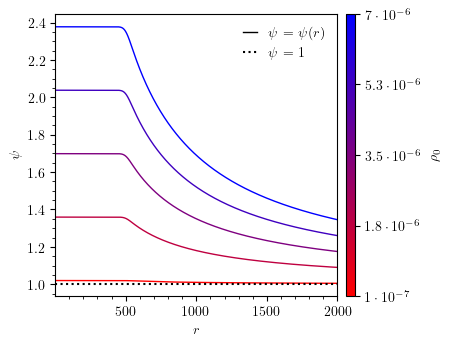

In [ ]:
scale = 0.7
fig_width_inches = textwidth * inch_per_cm * scale
desired_size_inches = fig_width_inches 

left_margin_frac = 0.15  
bottom_margin_frac = 0.15 
top_margin_frac = 0.05   
right_margin_frac = 0.05  

plot_area_width_frac = 1.0 - left_margin_frac - right_margin_frac
plot_area_height_frac = 1.0 - bottom_margin_frac - top_margin_frac

ax_size_frac = min(plot_area_width_frac * 0.8, plot_area_height_frac) 

cbar_width_frac = 0.02
pad_frac = 0.02

ax_left = left_margin_frac
ax_bottom = bottom_margin_frac
ax_width = ax_size_frac
ax_height = ax_size_frac 

cax_left = ax_left + ax_width + pad_frac
cax_bottom = ax_bottom
cax_width = cbar_width_frac
cax_height = ax_height 


fig = plt.figure(figsize=(desired_size_inches, desired_size_inches))
ax = fig.add_axes([ax_left, ax_bottom, ax_width, ax_height])
cax = fig.add_axes([cax_left, cax_bottom, cax_width, cax_height])

norm =  mcol.Normalize(vmin=np.min(scaled_parameters), vmax=np.max(scaled_parameters))
cmap = mcol.LinearSegmentedColormap.from_list("rbmap",["r","b"]) # mcol not defined, use standard cmap
colors = cmap(norm(scaled_parameters))

i = 0
for _r, _psi, in zip(scaled_r, scaled_psi):
    if i == 0:
        ax.plot(_r, _psi, color=colors[i], alpha=1, linewidth=1, label=r"$\psi\, = \psi(r)$")
    else:
        ax.plot(_r, _psi, color=colors[i], alpha=1, linewidth=1)
    i += 1

sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([]) # something cursed, it might pick up data from last plot

cbar = fig.colorbar(sm, cax=cax, orientation="vertical")

cbar.set_label(r"$\rho_0$", fontsize=10, labelpad=5)

tick_vals = np.linspace(scaled_parameters[0], scaled_parameters[-1], 5) 

#[scaled_parameters[0], np.mean(scaled_parameters), scaled_parameters[-1]]
cbar.set_ticks(np.unique(tick_vals))

def formatter(x, pos):
    if np.isclose(x, 0):
        return "0"
    else: # black magic
        scientific_notation = f"{x:.2e}"
        base, exponent = scientific_notation.split("e")
        base_f = float(base)
        return r"${:.2g} \cdot 10^{{{}}}$".format(base_f, int(exponent))

cbar.ax.yaxis.set_major_formatter(FuncFormatter(formatter))
cbar.ax.tick_params(labelsize=10)

ax.set_xlim(left=R_MIN, right=R_MAX)

# current_ticks = ax.get_xticks()
# ticks_to_add = [R_MIN]
# new_ticks = np.union1d(current_ticks, ticks_to_add)
# ax.set_xticks(new_ticks)

# final_tick_locations = ax.get_xticks()

# custom_labels = []
# for tick_val in final_tick_locations:
#     if np.isclose(tick_val, R_MIN):
#         custom_labels.append(r"$r_{\text{end}}$")
#     else:
#         custom_labels.append(f"{tick_val:.1f}")
    
# ax.set_xticklabels(custom_labels)

ax.axhline(y=1, color="black", linestyle="dotted", linewidth=1.5, label=r"$\psi\, = 1$")

ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$\psi$")

ax.minorticks_on()

# ax.text(0.85, 0.80, r"scaled", transform=ax.transAxes, fontsize=10, verticalalignment="top", horizontalalignment="right")
# ax.legend(loc="upper right", fancybox=False, framealpha=1, frameon=False, handlelength=1)

custom_handles = [
    Line2D([0], [0], color='black', linestyle='solid', linewidth=1, label=r"$\psi\, = \psi(r)$"),
    Line2D([0], [0], color='black', linestyle='dotted', linewidth=1.5, label=r"$\psi\, = 1$"),
]

ax.legend(handles=custom_handles, loc="upper right", fancybox=False, frameon=False, framealpha=1, handlelength=1)

plt.savefig("img/" + shell + "_scaled_psi.pdf", dpi=300, bbox_inches="tight")

In [99]:
# calculate areal radii

for alpha, r, psi in zip(scaled_alpha, scaled_r, scaled_psi):
    areal_radius = [_r * _psi_r**2 for _r, _psi_r in zip(r, psi)]
    scaled_areal_radii.append(areal_radius)

for alpha, r, psi in zip(unscaled_alpha, unscaled_r, unscaled_psi):
    areal_radius = [_r * _psi_r**2 for _r, _psi_r in zip(r, psi)]
    unscaled_areal_radii.append(areal_radius)

In [100]:
# calculate proper radii

for alpha, r, psi_r in zip(unscaled_alpha, scaled_r, scaled_psi):

    proper_radius = [0] # proper radius at r = 0 is 0
    integral = 0.0
    for k in range(1, len(r)):
        delta_r_k = r[k] - r[k - 1]
        integral += 0.5 * (psi_r[k]**2 + psi_r[k - 1]**2) * delta_r_k
        proper_radius.append(integral)

    scaled_proper_radii.append(proper_radius)

for alpha, r, psi_r in zip(unscaled_alpha, unscaled_r, unscaled_psi):

    proper_radius = [0] # proper radius at r = 0 is 0
    integral = 0.0
    for k in range(1, len(r)):
        delta_r_k = r[k] - r[k - 1]
        integral += 0.5 * (psi_r[k]**2 + psi_r[k - 1]**2) * delta_r_k
        proper_radius.append(integral)

    unscaled_proper_radii.append(proper_radius)

In [101]:
# # calculate ADM mass

# for alpha, r, psi_r, par in zip(unscaled_alpha, unscaled_r, unscaled_psi, unscaled_parameters):
#     rho = get_rho(par)
#     rho_r = [rho(_r) for _r in r]
#     ADM_mass = [0] # ADM mass at r = 0 is
#     integral = 0.0

#     for k in range(1, len(r)):
#         delta_r_k = r[k] - r[k - 1]

#         integral += 0.5 * (psi_r[k]**5 * rho_r[k] * r[k]**2 + psi_r[k - 1]**5 * rho_r[k - 1] * r[k - 1]**2) * delta_r_k

#         ADM_mass.append( 4 * np.pi * integral)

#     unscaled_ADM_mass.append(ADM_mass)

# for alpha, r, psi_r, par in zip(scaled_alpha, scaled_r, scaled_psi, scaled_parameters):
#     rho = get_rho(par)
#     rho_r = [rho(_r) for _r in r]
#     ADM_mass = [0] # ADM mass at r = 0 is 0
#     integral = 0.0

#     for k in range(1, len(r)):
#         delta_r_k = r[k] - r[k - 1]
#         if exponent == 0:
#             integral += 0.5 * (rho_r[k] * r[k]**2 + rho_r[k - 1] * r[k - 1]**2) * delta_r_k
#         else:
#             integral += 0.5 * (psi_r[k]**exponent * rho_r[k] * r[k]**2 + psi_r[k - 1]**exponent * rho_r[k - 1] * r[k - 1]**2) * delta_r_k

#         ADM_mass.append( 4 * np.pi * integral)
    
#     scaled_ADM_mass.append(ADM_mass)

In [102]:
# calculate rest mass

for alpha, r, psi_r, par in zip(unscaled_alpha, unscaled_r, unscaled_psi, unscaled_parameters):
    rho = get_rho(par)
    rho_r = [rho(_r) for _r in r]
    rest_mass = [0] # rest mass at r = 0 is
    integral = 0.0

    for k in range(1, len(r)):
        delta_r_k = r[k] - r[k - 1]

        integral += 0.5 * (psi_r[k]**6 * rho_r[k] * r[k]**2 + psi_r[k - 1]**6 * rho_r[k - 1] * r[k - 1]**2) * delta_r_k

        rest_mass.append( 4 * np.pi * integral)
    
    unscaled_rest_mass.append(rest_mass)


for alpha, r, psi_r, par in zip(scaled_alpha, scaled_r, scaled_psi, scaled_parameters):
    rho = get_rho(par)
    rho_r = [rho(_r) for _r in r]
    rest_mass = [0] # rest mass at r = 0 is 0
    integral = 0.0

    for k in range(1, len(r)):
        delta_r_k = r[k] - r[k - 1]
        if exponent == 0:
            integral += 0.5 * (rho_r[k] * r[k]**2 + rho_r[k - 1] * r[k - 1]**2) * delta_r_k
        else:
            integral += 0.5 * (psi_r[k]**(exponent+1) * rho_r[k] * r[k]**2 + psi_r[k - 1]**(exponent+1) * rho_r[k - 1] * r[k - 1]**2) * delta_r_k

        rest_mass.append( 4 * np.pi * integral)
    
    scaled_rest_mass.append(rest_mass)

In [103]:
for alpha, r, areal_r, proper_r, psi_r, par in zip(scaled_alpha, scaled_r, scaled_areal_radii, scaled_proper_radii, scaled_psi, scaled_parameters):
    rho = get_rho(par)
    _rho_r = [rho(_r) for _r in r]
    rho_r = [rho(_r) * _psi_r**(5 - exponent) for _r, _psi_r in zip(r, psi_r)]
    
    r_areal_r = np.interp(areal_r, areal_r, r) # r = r(areal radius)
    psi_areal_r = np.interp(areal_r, r, psi_r) # psi = psi(r(areal radius))

    rho_areal_r = [rho(_r_a_r) * _psi_a_r**(5 - exponent) for _r_a_r, _psi_a_r in zip(r_areal_r, psi_areal_r)]
    
    r_proper_r = np.interp(proper_r, proper_r, r) # r = r(proper radius)
    psi_proper_r = np.interp(proper_r, r, psi_r) # psi = psi(r(proper radius))
    rho_proper_r = [rho(_r_p_r) * _psi_p_r**(5 - exponent) for _r_p_r, _psi_p_r in zip(r_proper_r, psi_proper_r)]

    scaled_rho_r.append(_rho_r)
    scaled_rho_r_with_scaling.append(rho_r)
    scaled_rho_areal_r.append(rho_areal_r)
    scaled_rho_proper_r.append(rho_proper_r)

In [104]:
from matplotlib.colors import LinearSegmentedColormap

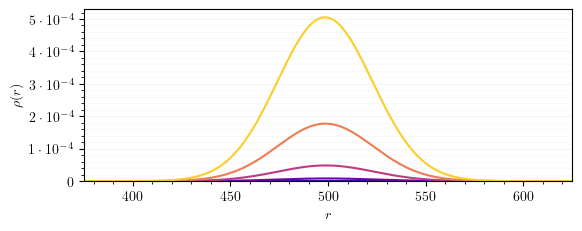

In [ ]:
fig_width_inches = textwidth * inch_per_cm
fig_height_inches = textheight * inch_per_cm / 4

fig, ax = plt.subplots(figsize=(fig_width_inches, fig_height_inches))

norm =  mcol.Normalize(vmin=np.min(scaled_ADM_mass), vmax=np.max(scaled_ADM_mass))
# cmap = cm.rainbow
# cmap = cm.Set1
# # cmap = mcol.LinearSegmentedColormap.from_list("rbmap",["r","b"]) 

original = plt.cm.plasma
cmap = LinearSegmentedColormap.from_list('inferno_trunc', original(np.linspace(0, 0.9, 256)))
colors = cmap(norm(scaled_ADM_mass))

i = 0
for par, r, rho_r_with_scaling in zip(scaled_parameters, scaled_r, scaled_rho_r_with_scaling):
    plt.plot(r, rho_r_with_scaling, color=colors[i], alpha=1, linewidth=1.5, label=(f"$\\rho_0$" + r"$\approx$" + formatter(par, 0)))
    i += 1
    
# sm = cm.ScalarMappable(norm=norm, cmap=cmap)
# sm.set_array([])
# cbar = plt.colorbar(sm, ax=ax, pad=0.03, orientation="horizontal", aspect=60, location="top", shrink=1)
# cbar.set_label(r"$M_{\text{ADM}}$", fontsize=10, labelpad=5)

# tick_vals = [scaled_ADM_mass[0], np.mean(scaled_ADM_mass), scaled_ADM_mass[-1]]
# tick_vals = np.unique(scaled_ADM_mass)
# cbar.set_ticks(np.unique(tick_vals))
# # cbar.ax.xaxis.set_major_formatter(FuncFormatter(formatter))

ax.yaxis.set_major_formatter(FuncFormatter(formatter))
ax.xaxis.get_offset_text().set_visible(False)
ax.yaxis.get_offset_text().set_visible(False)

ax.yaxis.grid(True, linestyle="-", linewidth=0.5, alpha=0.2, which='major')
ax.yaxis.grid(True, linestyle="-", linewidth=0.5, alpha=0.1, which='minor')
ax.minorticks_on()

ax.set_xlim(left=RADIUS- 5 * SIGMA, right=RADIUS + 5 * SIGMA) 
ax.set_ylim(bottom=0)
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$\rho(r)$")

# ax.text(0.05, 0.95, r"scaled", transform=ax.transAxes, fontsize=10, verticalalignment="top", horizontalalignment="left")


plt.savefig("img/" + shell + "_scaled_rho_r.pdf", dpi=300, bbox_inches="tight")

In [ ]:
# fig_width_inches = textwidth * inch_per_cm
# fig_height_inches = textheight * inch_per_cm / 4

# fig, ax = plt.subplots(figsize=(fig_width_inches, fig_height_inches))

# norm =  mcol.Normalize(vmin=np.min(scaled_ADM_mass), vmax=np.max(scaled_ADM_mass))
# cmap = cm.rainbow
# colors = cmap(norm(scaled_ADM_mass))

# i = 0
# for par, r, rho_r_with_scaling in zip(scaled_parameters, scaled_r, scaled_rho_r_with_scaling):
#     plt.plot(r, rho_r_with_scaling, color=colors[i], alpha=1, linewidth=1.5, label=(f"$\\rho_0$" + r"$\approx$" + formatter(par, 0)))
#     i += 1
    
# sm = cm.ScalarMappable(norm=norm, cmap=cmap)
# sm.set_array([])
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("top", size="5%", pad=0.05)

# cbar = plt.colorbar(sm, cax=cax, orientation="horizontal", aspect=60, location="top", shrink=1)
# cbar.set_label(r"$M_{\text{ADM}}$", fontsize=10, labelpad=5)

# tick_vals = [scaled_ADM_mass[0], np.mean(scaled_ADM_mass), scaled_ADM_mass[-1]]
# tick_vals = np.unique(scaled_ADM_mass)
# cbar.set_ticks(np.unique(tick_vals))

# ax.yaxis.set_major_formatter(FuncFormatter(formatter))
# ax.xaxis.get_offset_text().set_visible(False)
# ax.yaxis.get_offset_text().set_visible(False)

# ax.yaxis.grid(True, linestyle="-", linewidth=0.5, alpha=0.5, which='major')
# ax.yaxis.grid(True, linestyle="-", linewidth=0.5, alpha=0.1, which='minor')
# ax.minorticks_on()

# ax.set_xlim(left=0) 
# ax.set_ylim(bottom=0)
# ax.set_xlabel(r"$r$")
# ax.set_ylabel(r"$\rho(r)$")

# # ax.text(0.05, 0.95, r"scaled", transform=ax.transAxes, fontsize=10, verticalalignment="top", horizontalalignment="left")

# plt.savefig("img/" + shell + "_scaled_rho_r.pdf", dpi=300, bbox_inches="tight")

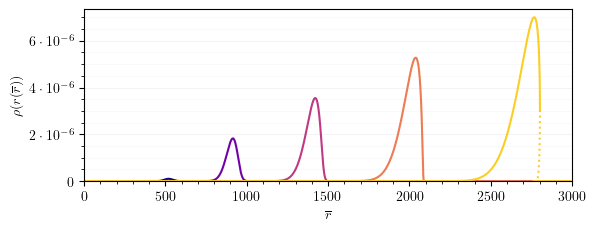

In [ ]:
fig_width_inches = textwidth * inch_per_cm
fig_height_inches = textheight * inch_per_cm / 4

fig, ax = plt.subplots(figsize=(fig_width_inches, fig_height_inches))

norm =  mcol.Normalize(vmin=np.min(scaled_ADM_mass), vmax=np.max(scaled_ADM_mass))
# cmap = cm.rainbow
# cmap = mcol.LinearSegmentedColormap.from_list("rbmap",["r","b"]) 
original = plt.cm.plasma
cmap = LinearSegmentedColormap.from_list('inferno_trunc', original(np.linspace(0, 0.9, 256)))
colors = cmap(norm(scaled_ADM_mass))

i = 0
for par, alpha, r, areal_r in zip(scaled_parameters, scaled_alpha, scaled_r, scaled_areal_radii):
    rho = get_rho(par)
    rho_r = [rho(_r) for _r in r]
    once = False
    if np.any(np.diff(areal_r) <= 0):
        monotonic_segments_a_r, monotonic_segments_r = get_monotonic_segments(areal_r, r)
        for r_segment, a_r_segment in zip(monotonic_segments_r, monotonic_segments_a_r):
            if np.any(np.diff(a_r_segment) <= 0):
                a_r_segment = np.flip(a_r_segment)
                r_segment = np.flip(r_segment)
                r_areal_r = np.interp(a_r_segment, a_r_segment, r_segment)
                rho_areal_r = [rho(_r_a_r) for _r_a_r in r_areal_r]
                a_r_segment = np.flip(a_r_segment)
                rho_areal_r = np.flip(rho_areal_r)
                if not once:
                    ax.plot(a_r_segment, rho_areal_r, color=colors[i], linestyle="dotted")
                    once = True
            else:
                r_areal_r = np.interp(a_r_segment, a_r_segment, r_segment)
                rho_areal_r = [rho(_r_a_r) for _r_a_r in r_areal_r]
                ax.plot(a_r_segment, rho_areal_r, color=colors[i], linewidth=1.5, label=(f"$\\rho_0$" + r"$\approx$" + formatter(par, 0)))
    else:
        r_areal_r = np.interp(areal_r, areal_r, r)
        rho_areal_r = [rho(_r_a_r) for _r_a_r in r_areal_r]
        ax.plot(areal_r, rho_areal_r, color=colors[i], linewidth=1.5, label=(f"$\\rho_0$" + r"$\approx$" + formatter(par, 0)))
    
    schwarzschild_radius = alpha
    schwarzschild_areal_radius = np.interp(schwarzschild_radius, r, areal_r)

    for horizon_info in scaled_horizons:
        if len(horizon_info) > 0:
            if horizon_info[0] == 2 * alpha:
                horizon_radii = [horizon_info[1] for horizon_info in scaled_horizons]
                horizon_areal_radii = np.interp(horizon_radii, r, areal_r)
    
    i += 1

# sm = cm.ScalarMappable(norm=norm, cmap=cmap)
# sm.set_array([])
# cbar = plt.colorbar(sm, ax=ax, pad=0.03, orientation="vertical", aspect=50, location="right", shrink=1)
# cbar.set_label("amplitude", fontsize=10, labelpad=5)

# #tick_vals = [scaled_ADM_mass[0], np.mean(scaled_ADM_mass), scaled_ADM_mass[-1]]
# tick_vals = np.unique(scaled_ADM_mass)
# cbar.set_ticks(np.unique(tick_vals))


# cbar.ax.yaxis.set_major_formatter(FuncFormatter(formatter))  # vertical colorbar -> .yaxis

ax.yaxis.set_major_formatter(FuncFormatter(formatter))

ax.xaxis.get_offset_text().set_visible(False)
ax.yaxis.get_offset_text().set_visible(False)

ax.set_xlim(0, 3000)
ax.set_ylim(bottom=0)

ax.yaxis.grid(True, linestyle="-", linewidth=0.5, alpha=0.2, which='major')
ax.yaxis.grid(True, linestyle="-", linewidth=0.5, alpha=0.1, which='minor')
ax.minorticks_on()

ax.set_xlabel(r"$\overline{r}$")
ax.set_ylabel(r"$\rho(r(\overline{r}))$")
#plt.legend()

# ax.text(0.05, 0.95, r"scaled", transform=ax.transAxes, fontsize=10, verticalalignment="top", horizontalalignment="left")

plt.savefig("img/" + shell + "_scaled_rho_areal_r.pdf", dpi=300, bbox_inches="tight")



In [ ]:
# fig_width_inches = textwidth * inch_per_cm
# fig_height_inches = textheight * inch_per_cm / 4

# fig, ax = plt.subplots(figsize=(fig_width_inches, fig_height_inches))


# norm =  mcol.Normalize(vmin=np.min(scaled_ADM_mass), vmax=np.max(scaled_ADM_mass))
# cmap = cm.rainbow
# colors = cmap(norm(scaled_ADM_mass))

# i = 0
# for par, proper_r, rho_proper_r in zip(scaled_parameters, scaled_proper_radii, scaled_rho_proper_r):
#     plt.plot(proper_r, rho_proper_r, color=colors[i], linewidth=1.5)
#     i += 1


# # sm = cm.ScalarMappable(norm=norm, cmap=cmap)
# # sm.set_array([])
# # cbar = plt.colorbar(sm, ax=ax, pad=0.03, orientation="vertical", aspect=50, location="right", shrink=1)
# # cbar.set_label("amplitude", fontsize=10, labelpad=5)

# # #tick_vals = [scaled_ADM_mass[0], np.mean(scaled_ADM_mass), scaled_ADM_mass[-1]]
# # tick_vals = np.unique(scaled_ADM_mass)
# # cbar.set_ticks(np.unique(tick_vals))
# # cbar.ax.yaxis.set_major_formatter(FuncFormatter(formatter))  # vertical colorbar -> .yaxis

# ax.yaxis.set_major_formatter(FuncFormatter(formatter))

# ax.yaxis.grid(True, linestyle="-", linewidth=0.5, alpha=0.5, which='major')
# ax.yaxis.grid(True, linestyle="-", linewidth=0.5, alpha=0.1, which='minor')
# ax.minorticks_on()

# ax.xaxis.get_offset_text().set_visible(False)
# ax.yaxis.get_offset_text().set_visible(False)
# ax.set_xlim(0, 4000)
# ax.set_ylim(bottom=0)

# plt.ylabel(r"$\rho(r(r^{\ast}))$")
# plt.xlabel(r"$r^{\ast}$")

# # ax.text(0.05, 0.95, r"scaled", transform=ax.transAxes, fontsize=10, verticalalignment="top", horizontalalignment="left")


# plt.savefig("img/" + shell + "_scaled_rho_proper_r.pdf", dpi=300, bbox_inches="tight")

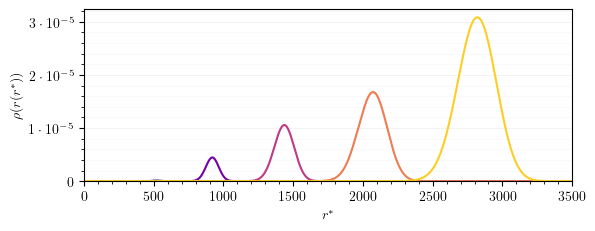

In [ ]:
fig_width_inches = textwidth * inch_per_cm
fig_height_inches = textheight * inch_per_cm / 4


fig, ax = plt.subplots(figsize=(fig_width_inches, fig_height_inches))


norm =  mcol.Normalize(vmin=np.min(scaled_ADM_mass), vmax=np.max(scaled_ADM_mass))
original = plt.cm.plasma
cmap = LinearSegmentedColormap.from_list('inferno_trunc', original(np.linspace(0, 0.9, 256)))
colors = cmap(norm(scaled_ADM_mass))

i = 0
for par, proper_r, rho_proper_r in zip(scaled_parameters, scaled_proper_radii, scaled_rho_proper_r):
    plt.plot(proper_r, rho_proper_r, color=colors[i], linewidth=1.5)
    i += 1


# sm = cm.ScalarMappable(norm=norm, cmap=cmap)
# sm.set_array([])
# cbar = plt.colorbar(sm, ax=ax, pad=0.03, orientation="vertical", aspect=50, location="right", shrink=1)
# cbar.set_label("amplitude", fontsize=10, labelpad=5)

# #tick_vals = [scaled_ADM_mass[0], np.mean(scaled_ADM_mass), scaled_ADM_mass[-1]]
# tick_vals = np.unique(scaled_ADM_mass)
# cbar.set_ticks(np.unique(tick_vals))
# cbar.ax.yaxis.set_major_formatter(FuncFormatter(formatter))  # vertical colorbar -> .yaxis

ax.yaxis.set_major_formatter(FuncFormatter(formatter))

ax.yaxis.grid(True, linestyle="-", linewidth=0.5, alpha=0.2, which='major')
ax.yaxis.grid(True, linestyle="-", linewidth=0.5, alpha=0.1, which='minor')
ax.minorticks_on()

ax.xaxis.get_offset_text().set_visible(False)
ax.yaxis.get_offset_text().set_visible(False)
ax.set_xlim(0, 3500)
ax.set_ylim(bottom=0)

plt.ylabel(r"$\rho(r(r^{\ast}))$")
plt.xlabel(r"$r^{\ast}$")

# ax.text(0.05, 0.95, r"scaled", transform=ax.transAxes, fontsize=10, verticalalignment="top", horizontalalignment="left")

plt.savefig(shell + "_scaled_rho_proper_r.pdf", dpi=300, bbox_inches="tight")

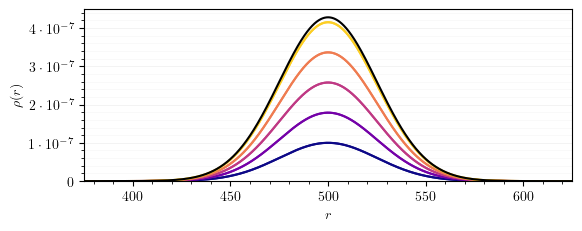

In [ ]:
fig_width_inches = textwidth * inch_per_cm
fig_height_inches = textheight * inch_per_cm / 4

fig, ax = plt.subplots(figsize=(fig_width_inches, fig_height_inches))

norm =  mcol.Normalize(vmin=np.min(unscaled_parameters), vmax=np.max(unscaled_parameters))
original = plt.cm.plasma
cmap = LinearSegmentedColormap.from_list('inferno_trunc', original(np.linspace(0, 0.9, 256)))
# cmap = cm.rainbow
# colors = cmap(norm(unscaled_parameters))


i = 0
for par, alpha, r in zip(unscaled_parameters, unscaled_alpha, unscaled_r):
    rho = get_rho(par)
    rho_r = [rho(_r) for _r in r]
    plt.plot(r, rho_r,color=cmap(norm(par)), linewidth=1.5)
    i += 1


rho = get_rho(critical_parameter)
rho_r = [rho(_r) for _r in unscaled_critical_r]
plt.plot(unscaled_critical_r, rho_r, color="black", linewidth=1.5)

# sm = cm.ScalarMappable(norm=norm, cmap=cmap)
# sm.set_array([])
# cbar = plt.colorbar(sm, ax=ax, pad=0.05, orientation="horizontal", aspect=60, location="top", shrink=1)
# cbar.set_label("amplitude", fontsize=10, labelpad=5)

# #tick_vals = [scaled_parameters[0], np.mean(scaled_parameters), scaled_parameters[-1]]
# tick_vals = np.unique(unscaled_parameters)
# cbar.set_ticks(np.unique(tick_vals))
# cbar.ax.xaxis.set_major_formatter(FuncFormatter(formatter))

ax.yaxis.set_major_formatter(FuncFormatter(formatter))
ax.xaxis.get_offset_text().set_visible(False)
ax.yaxis.get_offset_text().set_visible(False)

ax.yaxis.grid(True, linestyle="-", linewidth=0.5, alpha=0.2, which='major')
ax.yaxis.grid(True, linestyle="-", linewidth=0.5, alpha=0.1, which='minor')
ax.minorticks_on()

ax.set_xlim(left=RADIUS- 5 * SIGMA, right=RADIUS + 5 * SIGMA) 

ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$\rho(r)$")

# ax.set_xlim(left=R_MIN, right=R_MAX)
plt.ylim(bottom=0)
# plt.xlim(left=0)

# ax.text(0.95, 0.95, r"unscaled", transform=ax.transAxes, fontsize=10, verticalalignment="top", horizontalalignment="right")

plt.savefig("img/" + shell + "_unscaled_rho_r.pdf", dpi=300, bbox_inches="tight")


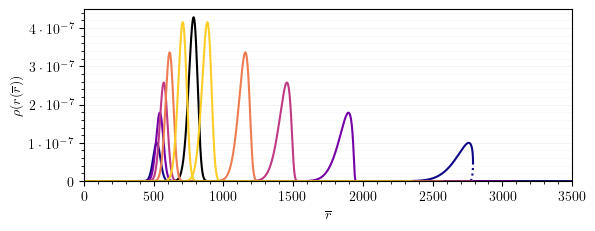

In [ ]:
fig_width_inches = textwidth * inch_per_cm
fig_height_inches = textheight * inch_per_cm / 4


fig, ax = plt.subplots(figsize=(fig_width_inches, fig_height_inches))

norm =  mcol.Normalize(vmin=np.min(unscaled_parameters), vmax=np.max(unscaled_parameters))
# cmap = cm.rainbow
original = cm.plasma
cmap = LinearSegmentedColormap.from_list('inferno_trunc', original(np.linspace(0, 0.9, 256)))
colors = cmap(norm(unscaled_parameters))


rho = get_rho(critical_parameter)
r_areal_r = np.interp(unscaled_critical_areal_radius, unscaled_critical_areal_radius, unscaled_critical_r) # r = r(areal radius)
rho_areal_r = [rho(_r_a_r) for _r_a_r in r_areal_r]
plt.plot(unscaled_critical_areal_radius, rho_areal_r, color="black", linewidth=1.5)

i = 0
for par, alpha, r, areal_r in zip(unscaled_parameters, unscaled_alpha, unscaled_r, unscaled_areal_radii):
    rho = get_rho(par)
    rho_r = [rho(_r) for _r in r]

    if np.any(np.diff(areal_r) <= 0):

        monotonic_segments_a_r, monotonic_segments_r = get_monotonic_segments(areal_r, r)
        for r_segment, a_r_segment in zip(monotonic_segments_r, monotonic_segments_a_r):
            if np.any(np.diff(a_r_segment) <= 0):
                a_r_segment = np.flip(a_r_segment)
                r_segment = np.flip(r_segment)
                r_areal_r = np.interp(a_r_segment, a_r_segment, r_segment) # r = r(areal radius)
                rho_areal_r = [rho(_r_a_r) for _r_a_r in r_areal_r]
                a_r_segment = np.flip(a_r_segment)
                rho_areal_r = np.flip(rho_areal_r)
                plt.plot(a_r_segment, rho_areal_r, color=cmap(norm(par)), linestyle="dotted", linewidth=1.5)
            
            else:
                r_areal_r = np.interp(a_r_segment, a_r_segment, r_segment) # r = r(areal radius)
                rho_areal_r = [rho(_r_a_r) for _r_a_r in r_areal_r]
                plt.plot(a_r_segment, rho_areal_r, color=cmap(norm(par)), linewidth=1.5)
           
    else:
        r_areal_r = np.interp(areal_r, areal_r, r) # r = r(areal radius)
        rho_areal_r = [rho(_r_a_r) for _r_a_r in r_areal_r]
        plt.plot(areal_r, rho_areal_r,color=cmap(norm(par)), linewidth=1.5)
    
    schwarzschild_radius = alpha
    schwarzschild_areal_radius = np.interp(schwarzschild_radius, r, areal_r)

    for horizon_info in unscaled_horizons:
        if len(horizon_info) > 0:
            if horizon_info[0] == 2*alpha:
                horizon_radii = [horizon_info[1] for horizon_info in unscaled_horizons]
                horizon_areal_radii = np.interp(horizon_radii, r, areal_r)
                i += 1
# sm = cm.ScalarMappable(norm=norm, cmap=cmap)
# sm.set_array([])
# cbar = plt.colorbar(sm, ax=ax, pad=0.03, orientation="vertical", aspect=50, location="right", shrink=1)
# cbar.set_label("amplitude", fontsize=10, labelpad=5)

# #tick_vals = [scaled_parameters[0], np.mean(scaled_parameters), scaled_parameters[-1]]
# tick_vals = np.unique(unscaled_parameters)
# cbar.set_ticks(np.unique(tick_vals))
# cbar.ax.yaxis.set_major_formatter(FuncFormatter(formatter))  # vertical colorbar -> .yaxis

ax.yaxis.set_major_formatter(FuncFormatter(formatter))

ax.xaxis.get_offset_text().set_visible(False)
ax.yaxis.get_offset_text().set_visible(False)

plt.xlim(0, 3500)
plt.ylim(bottom=0)


ax.yaxis.grid(True, linestyle="-", linewidth=0.5, alpha=0.2, which='major')
ax.yaxis.grid(True, linestyle="-", linewidth=0.5, alpha=0.1, which='minor')
ax.minorticks_on()

ax.set_xlabel(r"$\overline{r}$")
ax.set_ylabel(r"$\rho(r(\overline{r}))$")
# ax.text(0.95, 0.95, r"unscaled", transform=ax.transAxes, fontsize=10, verticalalignment="top", horizontalalignment="right")

plt.axhline(y=0, color="black", linewidth=1)

# ax.set_ylim(bottom=0, top=0.5e-7)

plt.savefig("img/" + shell + "_unscaled_rho_areal_r.pdf", dpi=300, bbox_inches="tight")


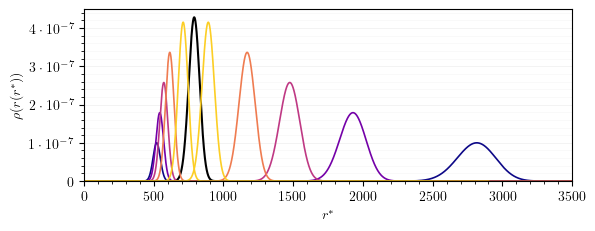

In [ ]:
fig_width_inches = textwidth * inch_per_cm
fig_height_inches = textheight * inch_per_cm / 4

fig, ax = plt.subplots(figsize=(fig_width_inches, fig_height_inches))

norm =  mcol.Normalize(vmin=np.min(unscaled_parameters), vmax=np.max(unscaled_parameters))
original = plt.cm.plasma
cmap = LinearSegmentedColormap.from_list("truncated", original(np.linspace(0, 0.9, 256)))
# cmap = cm.rainbow
colors = cmap(norm(unscaled_parameters))


rho = get_rho(critical_parameter)
r_proper_r = np.interp(unscaled_critical_proper_radius, unscaled_critical_proper_radius, unscaled_critical_r) # r = r(proper radius)
rho_proper_r = [rho(_r_a_r) for _r_a_r in r_proper_r]
plt.plot(unscaled_critical_proper_radius, rho_proper_r, color="black", linewidth=1.5)

norm =  mcol.Normalize(vmin=min(unscaled_parameters), vmax=max(unscaled_parameters))
cmap = cm.rainbow   
sm = cm.ScalarMappable(norm=norm, cmap=cmap)

i = 0
for par, alpha, r, proper_r in zip(unscaled_parameters, unscaled_alpha, unscaled_r, unscaled_proper_radii):
    rho = get_rho(par)
    rho_r = [rho(_r) for _r in r]

   
    r_proper_r = np.interp(proper_r, proper_r, r) # r = r(proper radius)
    rho_proper_r = [rho(_r_p_r) for _r_p_r in r_proper_r]
    plt.plot(proper_r, rho_proper_r,color=colors[i], linewidth=1.2)
    i += 1
plt.xlim(200, 3000)
plt.ylim(bottom=0)
plt.xlabel("proper radius")
plt.ylabel("density")


# sm = cm.ScalarMappable(norm=norm, cmap=cmap)
# sm.set_array([])
# cbar = plt.colorbar(sm, ax=ax, pad=0.03, orientation="vertical", aspect=50, location="right", shrink=1)
# cbar.set_label("amplitude", fontsize=10, labelpad=5)

# #tick_vals = [scaled_parameters[0], np.mean(scaled_parameters), scaled_parameters[-1]]
# tick_vals = np.unique(unscaled_parameters)
# cbar.set_ticks(np.unique(tick_vals))

# cbar.ax.yaxis.set_major_formatter(FuncFormatter(formatter))  # vertical colorbar -> .yaxis

ax.yaxis.set_major_formatter(FuncFormatter(formatter))

ax.xaxis.get_offset_text().set_visible(False)
ax.yaxis.get_offset_text().set_visible(False)

plt.axhline(y=0, color="black", linewidth=1)

ax.yaxis.grid(True, linestyle="-", linewidth=0.5, alpha=0.2, which='major')
ax.yaxis.grid(True, linestyle="-", linewidth=0.5, alpha=0.1, which='minor')
ax.minorticks_on()


ax.set_ylim(bottom=0)
ax.set_xlim(left=0, right=3500)
plt.ylabel(r"$\rho(r(r^{\ast}))$")
plt.xlabel(r"$r^{\ast}$")

# ax.text(0.95, 0.95, r"unscaled", transform=ax.transAxes, fontsize=10, verticalalignment="top", horizontalalignment="right")

plt.savefig("img/" + shell + "_unscaled_rho_proper_r.pdf", dpi=300, bbox_inches="tight")


In [113]:
# calculate the embedding

for alpha, psi_r, dpsi_r, r, areal_r in zip(scaled_alpha, scaled_psi, scaled_dpsi, scaled_r, scaled_areal_radii):
   
    @njit
    def z_ode_scaled(x: float, y: np.ndarray) -> np.ndarray:
        psi_x = np.interp(x, r, psi_r)
        dpsi_x = np.interp(x, r, dpsi_r)
        y = np.sqrt(-4*x*dpsi_x * (psi_x**2 + x* dpsi_x))
        return np.array([y])


    _, z = rk4(z_ode_scaled, R_MAX, np.array([0]), R_MIN, STEP) # use same paramaters as for the other ODEs for simplicity

    z = z.flatten()
    z = z - min(z) # shift to zero
    z = np.flip(z)

    if len(z) != len(r):
        print("Warning: z and r have different lengths!")

    r = r[~np.isnan(z)]
    psi_r = psi_r[~np.isnan(z)]
    areal_r = np.array(areal_r)[~np.isnan(z)]
    z = z[~np.isnan(z)]
    

    if np.any(np.diff(r) <= 0): # is proper radius increasing
            print("Warning: r is not increasing! Interpolation will silently fail")


    r_areal_r = np.interp(areal_r, areal_r, r)
    z_r_areal_r = np.interp(r_areal_r, r, z)

    scaled_embedding_z.append(z_r_areal_r)
    scaled_embedding_areal_r.append(r_areal_r)

In [114]:
def get_monotonic_segments(values, other_values=None):
    
    interval_partition_indices = []
    interval_partition_indices.append(0)

    increasing = True
    for i in range(1, len(values)):
        if values[i] < values[i - 1]:
            if increasing:
                interval_partition_indices.append(i - 1)

                increasing = False
            else:
                continue
        else:
            if not increasing:
                interval_partition_indices.append(i - 1)
                increasing = True
            else:
                continue
    interval_partition_indices.append(len(values) - 1)

    subintervals = []
    # separate values into subarrays based on the indices
    for i in range(len(interval_partition_indices) - 1):
        start = interval_partition_indices[i]
        end = interval_partition_indices[i + 1] + 1
        subintervals.append(values[start:end])

    if other_values is not None:
        other_subintervals = []
        for i in range(len(interval_partition_indices) - 1):
            start = interval_partition_indices[i]
            end = interval_partition_indices[i + 1] + 1
            other_subintervals.append(other_values[start:end])
        return subintervals, other_subintervals
    else:
        # if no other values are provided, return only the subintervals
        return subintervals

In [115]:
# def overlaping_concatenate(arrays):
#     tmp = []
#     last_array = arrays[-1]
#     for array in arrays:
#         if np.all(array == last_array):
#             print(array)
#             tmp.append(array)
#         else:
#             print(array[:-1])
#             tmp.append(array[:-1])
#     return np.concatenate(tmp)
    

In [116]:
unscaled_embedding_z = []
unscaled_embedding_areal_r = []

for alpha, psi_r, dpsi_r, r, areal_r in zip(unscaled_alpha, unscaled_psi, unscaled_dpsi, unscaled_r, unscaled_areal_radii):
   
    @njit
    def z_ode_unscaled(x: float, y: np.ndarray) -> np.ndarray:
        psi_x = np.interp(x, r, psi_r)
        dpsi_x = np.interp(x, r, dpsi_r)
        y = np.sqrt(-4*x*dpsi_x * (psi_x**2 + x* dpsi_x))
        return np.array([y])


    _, z = rk4(z_ode_unscaled, R_MAX, np.array([0]), R_MIN, STEP) # use same paramaters as for the other ODEs for simplicity

    z = z.flatten()
    z = z - min(z) # shift to zero
    z = np.flip(z)

    if len(z) != len(r):
        print("Warning: z and r have different lengths!")

    r = r[~np.isnan(z)] 
    psi_r = psi_r[~np.isnan(z)]
    areal_r = np.array(areal_r)[~np.isnan(z)]
    z = z[~np.isnan(z)]
    

    if np.any(np.diff(areal_r) <= 0): # is proper radius increasing
            monotonic_segments_a_r, monotonic_segments_r = get_monotonic_segments(areal_r, r)
            _, monotonic_segments_z = get_monotonic_segments(areal_r, z)


            resulting_areal_r = []
            resulting_z_r_areal_r = []

                 
            for r_segment, a_r_segment, z_segment in zip(monotonic_segments_r, monotonic_segments_a_r, monotonic_segments_z):

                if np.any(np.diff(a_r_segment) <= 0):
                    a_r_segment = np.flip(a_r_segment)
                    r_segment = np.flip(r_segment)
                    z_segment = np.flip(z_segment)
                    _r_areal_r = np.interp(a_r_segment, a_r_segment, r_segment)
                    
                    r_segment = np.flip(r_segment)
                    _r_areal_r = np.flip(_r_areal_r)
                    _z_r_areal_r = np.interp(_r_areal_r, r_segment, z_segment)
    
                    a_r_segment = np.flip(a_r_segment)
                    _z_r_areal_r = np.flip(_z_r_areal_r)

                else:
                    _r_areal_r = np.interp(a_r_segment, a_r_segment, r_segment)
                    _z_r_areal_r = np.interp(_r_areal_r, r_segment, z_segment)
                    

                if len(a_r_segment) != len(monotonic_segments_a_r[-1]):
                    resulting_areal_r.append(a_r_segment[:-1])
                    resulting_z_r_areal_r.append(_z_r_areal_r[:-1])

                elif np.all(a_r_segment == monotonic_segments_a_r[-1]):
                    resulting_areal_r.append(a_r_segment)
                    resulting_z_r_areal_r.append(_z_r_areal_r)
                else:
                    resulting_areal_r.append(a_r_segment[:-1])
                    resulting_z_r_areal_r.append(_z_r_areal_r[:-1])
                    
            new_areal_r = np.concatenate(resulting_areal_r)
            z_r_areal_r = np.concatenate(resulting_z_r_areal_r)
    else:
        r_areal_r = np.interp(areal_r, areal_r, r)
        z_r_areal_r = np.interp(r_areal_r, r, z)
        new_areal_r = areal_r

    unscaled_embedding_z.append(z_r_areal_r)
    unscaled_embedding_areal_r.append(new_areal_r)


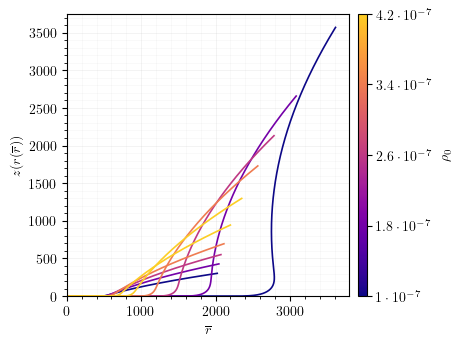

In [ ]:
scale = 0.7
fig_width_inches = textwidth * inch_per_cm * scale
desired_size_inches = fig_width_inches 

left_margin_frac = 0.15  
bottom_margin_frac = 0.15 
top_margin_frac = 0.05   
right_margin_frac = 0.05  

plot_area_width_frac = 1.0 - left_margin_frac - right_margin_frac
plot_area_height_frac = 1.0 - bottom_margin_frac - top_margin_frac

ax_size_frac = min(plot_area_width_frac * 0.8, plot_area_height_frac) 

cbar_width_frac = 0.02
pad_frac = 0.02

ax_left = left_margin_frac
ax_bottom = bottom_margin_frac
ax_width = ax_size_frac
ax_height = ax_size_frac 

cax_left = ax_left + ax_width + pad_frac
cax_bottom = ax_bottom
cax_width = cbar_width_frac
cax_height = ax_height 


fig = plt.figure(figsize=(desired_size_inches, desired_size_inches))
ax = fig.add_axes([ax_left, ax_bottom, ax_width, ax_height])
cax = fig.add_axes([cax_left, cax_bottom, cax_width, cax_height])


norm =  mcol.Normalize(vmin=min(unscaled_parameters), vmax=max(unscaled_parameters))
# cmap = cm.rainbow   
original = cm.plasma
cmap = LinearSegmentedColormap.from_list('inferno_trunc', original(np.linspace(0, 0.9, 256)))
colors = cmap(norm(unscaled_parameters))

i = 0

for par, alpha, r, z in zip(unscaled_parameters, unscaled_parameters, unscaled_embedding_areal_r, unscaled_embedding_z):
    ax.plot(r, z, color=colors[i], linewidth=1.2)
    i += 1

sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([]) # something cursed, it might pick up data from last plot

cbar = fig.colorbar(sm, cax=cax, orientation="vertical")

cbar.set_label(r"$\rho_0$", fontsize=10, labelpad=5)

tick_vals = np.linspace(min(unscaled_parameters), max(unscaled_parameters), 5) 

#[unscaled_parameters[0], np.mean(unscaled_parameters), unscaled_parameters[-1]]
cbar.set_ticks(np.unique(tick_vals))

def formatter(x, pos):
    if np.isclose(x, 0):
        return "0"
    else: # black magic
        scientific_notation = f"{x:.2e}"
        base, exponent = scientific_notation.split("e")
        base_f = float(base)
        return r"${:.2g} \cdot 10^{{{}}}$".format(base_f, int(exponent))

cbar.ax.yaxis.set_major_formatter(FuncFormatter(formatter))
cbar.ax.tick_params(labelsize=10)

ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

# ax.text(0.05, 0.95, r"unscaled", transform=ax.transAxes, fontsize=10, verticalalignment="top", horizontalalignment="left")

ax.grid(True, linestyle="-", linewidth=0.5, alpha=0.2, which='major')
ax.grid(True, linestyle="-", linewidth=0.5, alpha=0.1, which='minor')

ax.minorticks_on()

ax.set_xlabel(r"$\overline{r}$")
ax.set_ylabel(r"$z(r(\overline{r}))$")

plt.savefig("img/" + shell + "_unscaled_z.pdf", dpi=300, bbox_inches="tight")

In [118]:
scaled_embedding_z = []
scaled_embedding_areal_r = []

for alpha, psi_r, dpsi_r, r, areal_r in zip(scaled_alpha, scaled_psi, scaled_dpsi, scaled_r, scaled_areal_radii):
   
    @njit
    def z_ode_scaled(x: float, y: np.ndarray) -> np.ndarray:
        psi_x = np.interp(x, r, psi_r)
        dpsi_x = np.interp(x, r, dpsi_r)
        y = np.sqrt(-4*x*dpsi_x * (psi_x**2 + x* dpsi_x))
        return np.array([y])


    _, z = rk4(z_ode_scaled, R_MAX, np.array([0]), R_MIN, STEP) # use same paramaters as for the other ODEs for simplicity

    z = z.flatten()
    z = z - min(z) # shift to zero
    z = np.flip(z)

    if len(z) != len(r):
        print("Warning: z and r have different lengths!")

    r = r[~np.isnan(z)] 
    psi_r = psi_r[~np.isnan(z)]
    areal_r = np.array(areal_r)[~np.isnan(z)]
    z = z[~np.isnan(z)]
    

    if np.any(np.diff(areal_r) <= 0): # is proper radius increasing
            monotonic_segments_a_r, monotonic_segments_r = get_monotonic_segments(areal_r, r)
            _, monotonic_segments_z = get_monotonic_segments(areal_r, z)


            resulting_areal_r = []
            resulting_z_r_areal_r = []

                 
            for r_segment, a_r_segment, z_segment in zip(monotonic_segments_r, monotonic_segments_a_r, monotonic_segments_z):

                if np.any(np.diff(a_r_segment) <= 0):
                    a_r_segment = np.flip(a_r_segment)
                    r_segment = np.flip(r_segment)
                    z_segment = np.flip(z_segment)
                    _r_areal_r = np.interp(a_r_segment, a_r_segment, r_segment)
                    
                    r_segment = np.flip(r_segment)
                    _r_areal_r = np.flip(_r_areal_r)
                    _z_r_areal_r = np.interp(_r_areal_r, r_segment, z_segment)
    
                    a_r_segment = np.flip(a_r_segment)
                    _z_r_areal_r = np.flip(_z_r_areal_r)

                else:
                    _r_areal_r = np.interp(a_r_segment, a_r_segment, r_segment)
                    _z_r_areal_r = np.interp(_r_areal_r, r_segment, z_segment)
                    

                if len(a_r_segment) != len(monotonic_segments_a_r[-1]):
                    resulting_areal_r.append(a_r_segment[:-1])
                    resulting_z_r_areal_r.append(_z_r_areal_r[:-1])

                elif np.all(a_r_segment == monotonic_segments_a_r[-1]):
                    resulting_areal_r.append(a_r_segment)
                    resulting_z_r_areal_r.append(_z_r_areal_r)
                else:
                    resulting_areal_r.append(a_r_segment[:-1])
                    resulting_z_r_areal_r.append(_z_r_areal_r[:-1])
                    
            new_areal_r = np.concatenate(resulting_areal_r)
            z_r_areal_r = np.concatenate(resulting_z_r_areal_r)
    else:
        r_areal_r = np.interp(areal_r, areal_r, r)
        z_r_areal_r = np.interp(r_areal_r, r, z)
        new_areal_r = areal_r

    scaled_embedding_z.append(z_r_areal_r)
    scaled_embedding_areal_r.append(new_areal_r)


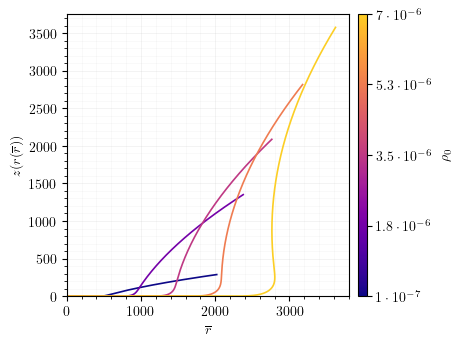

In [ ]:
scale = 0.7
fig_width_inches = textwidth * inch_per_cm * scale
desired_size_inches = fig_width_inches 

left_margin_frac = 0.15  
bottom_margin_frac = 0.15 
top_margin_frac = 0.05   
right_margin_frac = 0.05  

plot_area_width_frac = 1.0 - left_margin_frac - right_margin_frac
plot_area_height_frac = 1.0 - bottom_margin_frac - top_margin_frac

ax_size_frac = min(plot_area_width_frac * 0.8, plot_area_height_frac) 

cbar_width_frac = 0.02
pad_frac = 0.02

ax_left = left_margin_frac
ax_bottom = bottom_margin_frac
ax_width = ax_size_frac
ax_height = ax_size_frac 

cax_left = ax_left + ax_width + pad_frac
cax_bottom = ax_bottom
cax_width = cbar_width_frac
cax_height = ax_height 


fig = plt.figure(figsize=(desired_size_inches, desired_size_inches))
ax = fig.add_axes([ax_left, ax_bottom, ax_width, ax_height])
cax = fig.add_axes([cax_left, cax_bottom, cax_width, cax_height])


norm =  mcol.Normalize(vmin=min(scaled_parameters), vmax=max(scaled_parameters))
# cmap = cm.rainbow   
original = cm.plasma
cmap = LinearSegmentedColormap.from_list('inferno_trunc', original(np.linspace(0, 0.9, 256)))
colors = cmap(norm(scaled_parameters))

i = 0

for par, alpha, r, z in zip(scaled_parameters, scaled_parameters, scaled_embedding_areal_r, scaled_embedding_z):
    ax.plot(r, z, color=colors[i], linewidth=1.2)
    i += 1

sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([]) # something cursed, it might pick up data from last plot

cbar = fig.colorbar(sm, cax=cax, orientation="vertical")

cbar.set_label(r"$\rho_0$", fontsize=10, labelpad=5)

tick_vals = np.linspace(min(scaled_parameters), max(scaled_parameters), 5) 

#[unscaled_parameters[0], np.mean(unscaled_parameters), unscaled_parameters[-1]]
cbar.set_ticks(np.unique(tick_vals))

def formatter(x, pos):
    if np.isclose(x, 0):
        return "0"
    else: # black magic
        scientific_notation = f"{x:.2e}"
        base, exponent = scientific_notation.split("e")
        base_f = float(base)
        return r"${:.2g} \cdot 10^{{{}}}$".format(base_f, int(exponent))

cbar.ax.yaxis.set_major_formatter(FuncFormatter(formatter))
cbar.ax.tick_params(labelsize=10)

ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

# ax.text(0.05, 0.95, r"scaled", transform=ax.transAxes, fontsize=10, verticalalignment="top", horizontalalignment="left")


ax.grid(True, linestyle="-", linewidth=0.5, alpha=0.2, which='major')
ax.grid(True, linestyle="-", linewidth=0.5, alpha=0.1, which='minor')
ax.minorticks_on()

ax.set_xlabel(r"$\overline{r}$")
ax.set_ylabel(r"$z(r(\overline{r}))$")

plt.savefig("img/" + shell + "_scaled_z.pdf", dpi=300, bbox_inches="tight")

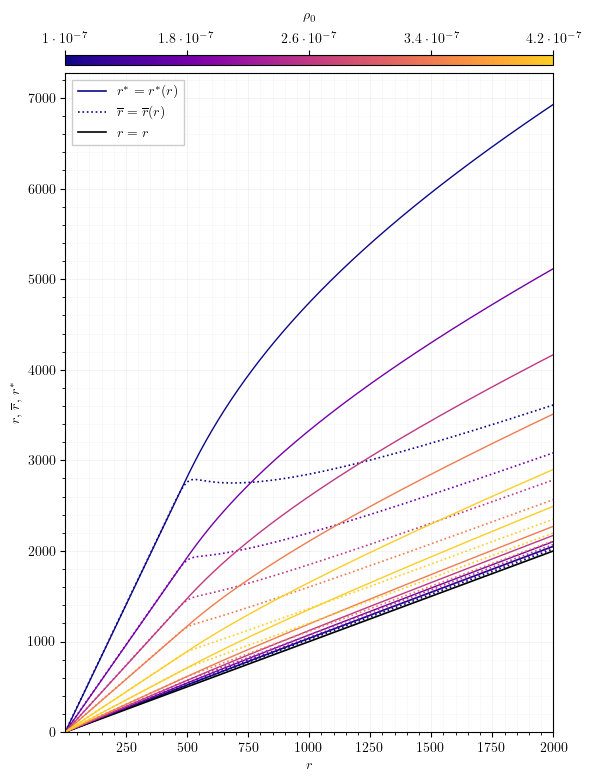

In [ ]:
fig_width_inches = textwidth * inch_per_cm
fig_height_inches = textwidth * inch_per_cm / golden_ratio 

fig, ax = plt.subplots(figsize=(fig_width_inches, fig_height_inches))

norm =  mcol.Normalize(vmin=np.min(unscaled_parameters), vmax=np.max(unscaled_parameters))
# cmap = cm.rainbow
original = cm.plasma
cmap = LinearSegmentedColormap.from_list('inferno_trunc', original(np.linspace(0, 0.9, 256)))
colors = cmap(norm(unscaled_parameters))

once = False
i = 0
for alpha, r, areal_r, proper_r in zip(unscaled_alpha, unscaled_r, unscaled_areal_radii, unscaled_proper_radii):

    if not once:
        ax.plot(r, proper_r, color=colors[i], linewidth=1.2, label=r"$r^{\ast} = r^{\ast}(r)$")
        ax.plot(r, areal_r, color=colors[i], linestyle="dotted", linewidth=1.2, label = r"$\overline{r} = \overline{r}(r)$")
    else:
        ax.plot(r, proper_r, color=colors[i], linewidth=1)
        ax.plot(r, areal_r, color=colors[i], linestyle="dotted", linewidth=1.2)

    if not once:
        ax.plot(r, r, color="black", linestyle="-", linewidth=1.2, label = r"$r = r$")
        once = True
    
    i += 1


sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.01, orientation="horizontal", aspect=50, location="top", shrink=1)
cbar.set_label(r"$\rho_0$", fontsize=10, labelpad=10)

#tick_vals = [unscaled_parameters[0], np.mean(unscaled_parameters), unscaled_parameters[-1]]
tick_vals = np.unique(unscaled_parameters)
cbar.set_ticks(np.unique(tick_vals))
cbar.ax.xaxis.set_major_formatter(FuncFormatter(formatter))


ax.grid(True, linestyle="-", linewidth=0.5, alpha=0.2, which='major')
ax.grid(True, linestyle="-", linewidth=0.5, alpha=0.1, which='minor')
ax.minorticks_on()

# ax.text(0.05, 0.88, r"scaled", transform=ax.transAxes, fontsize=10, verticalalignment="top", horizontalalignment="left")

plt.ylim(bottom=0)
plt.xlim(R_MIN, R_MAX)
plt.xlabel(r"$r$")
plt.ylabel(r"$r,\, \overline{r},\, r^{\ast}$")
plt.legend(loc="upper left", fontsize=10, fancybox=False, framealpha=1, frameon=True)


plt.savefig("img/" + shell + "_unscaled_radii.pdf", dpi=300, bbox_inches="tight")

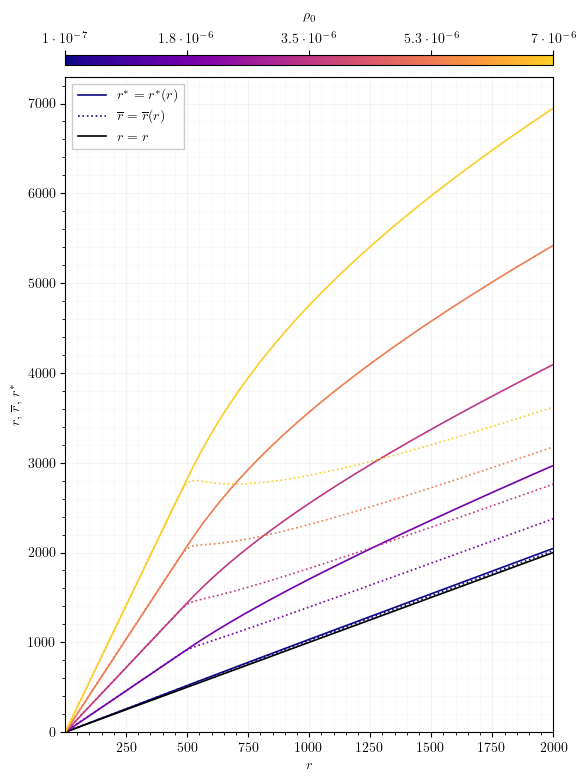

In [ ]:
fig_width_inches = textwidth * inch_per_cm
fig_height_inches = textwidth * inch_per_cm / golden_ratio

fig, ax = plt.subplots(figsize=(fig_width_inches, fig_height_inches))
original = cm.plasma
cmap = LinearSegmentedColormap.from_list('inferno_trunc', original(np.linspace(0, 0.9, 256)))
norm =  mcol.Normalize(vmin=np.min(scaled_parameters), vmax=np.max(scaled_parameters))
# cmap = cm.rainbow

colors = cmap(norm(scaled_parameters))

once = False
i = 0
for alpha, r, areal_r, proper_r in zip(scaled_alpha, scaled_r, scaled_areal_radii, scaled_proper_radii):
    if not once:
        ax.plot(r, proper_r, color=colors[i], linewidth=1.2, label=r"$r^{\ast} = r^{\ast}(r)$")
        ax.plot(r, areal_r, color=colors[i], linestyle="dotted", linewidth=1.2, label = r"$\overline{r} = \overline{r}(r)$")
    else:
        ax.plot(r, proper_r, color=colors[i], linewidth=1.2)
        ax.plot(r, areal_r, color=colors[i], linestyle="dotted", linewidth=1.2)

    if not once:
        ax.plot(r, r, color="black", linestyle="-", linewidth=1.2, label = r"$r = r$")
        once = True
    
    i += 1


sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.015, orientation="horizontal", aspect=50, location="top", shrink=1)
cbar.set_label(r"$\rho_0$", fontsize=10, labelpad=10)

#tick_vals = [scaled_parameters[0], np.mean(scaled_parameters), scaled_parameters[-1]]
tick_vals = np.unique(scaled_parameters)
cbar.set_ticks(np.unique(tick_vals))
cbar.ax.xaxis.set_major_formatter(FuncFormatter(formatter))  # vertical colorbar -> .yaxis

# ax.text(0.05, 0.88, r"scaled", transform=ax.transAxes, fontsize=10, verticalalignment="top", horizontalalignment="left")


ax.grid(True, linestyle="-", linewidth=0.5, alpha=0.2, which='major')
ax.grid(True, linestyle="-", linewidth=0.5, alpha=0.1, which='minor')
ax.minorticks_on()

plt.ylim(bottom=0)
plt.xlim(R_MIN, R_MAX)
plt.xlabel(r"$r$")
plt.ylabel(r"$r,\, \overline{r},\, r^{\ast}$")
plt.legend(loc="upper left", fontsize=10, fancybox=False, framealpha=1, frameon=True)


plt.savefig("img/" + shell + "_scaled_radii.pdf", dpi=300, bbox_inches="tight")

In [122]:
# for alpha, r, z in zip(scaled_alpha, scaled_embedding_areal_r, scaled_embedding_z):

#     fig = plt.figure(figsize=(10, 10))
#     ax = fig.add_subplot(111, projection="3d")

#     theta_vals = np.linspace(0, 2*np.pi, 180)

#     X = np.outer(r, np.cos(theta_vals))
#     Y = np.outer(r, np.sin(theta_vals))
#     Z = np.outer(z, np.ones_like(theta_vals))

#     ax.plot_wireframe(X, Y, Z,
#                     rstride=1000,   # how many radial steps to skip
#                     cstride=20,  # how many angular steps to skip
#                     color="black",
#                     linewidth=1)


#     # no background box
#     ax.xaxis.pane.fill = False
#     ax.yaxis.pane.fill = False
#     ax.zaxis.pane.fill = False
#     # no grid   
#     ax.grid(False)
#     fig.patch.set_facecolor("white")
#     ax.set_facecolor("white")

#     ax.xaxis.pane.set_visible(False)  # hide the "walls"
#     ax.yaxis.pane.set_visible(False)
#     ax.zaxis.pane.set_visible(False)

#     x_min, x_max = X.min(), X.max()
#     y_min, y_max = Y.min(), Y.max()
#     z_min, z_max = Z.min(), Z.max()

#     x_range = x_max - x_min
#     y_range = y_max - y_min
#     z_range = z_max - z_min

#     ax.set_box_aspect((1 * x_range, 1 * y_range, 1 * z_range))
#     plt.ylabel("r (areal)")
#     plt.xlabel("r (areal)")
#     ax.set_zlabel("z (r)")

#     # # Contour on the "floor" (z = z_min)
#     # ax.contour(X, Y, Z, zdir="z", offset=z_min, colors="red", linewidths=0.5, levels=20)

#     # # Contour on the other "side" in Y at y = y_min
#     # ax.contour(X, Y, Z, zdir="y", offset=y_min, colors="red", linewidths=0.5, levels=20)

#     plt.tight_layout()

#     ax.set_proj_type("persp", focal_length=0.5)  # 0.5 => wide angle
#     ax.view_init(elev=10, azim=45)
#     plt.show()

In [123]:
# for alpha, r, z in zip(unscaled_alpha, unscaled_embedding_areal_r, unscaled_embedding_z):

#     fig = plt.figure(figsize=(10, 10))
#     ax = fig.add_subplot(111, projection="3d")

#     theta_vals = np.linspace(0, 2*np.pi, 180)

#     X = np.outer(r, np.cos(theta_vals))
#     Y = np.outer(r, np.sin(theta_vals))
#     Z = np.outer(z, np.ones_like(theta_vals))

#     ax.plot_wireframe(X, Y, Z,
#                     rstride=1000,   # how many radial steps to skip
#                     cstride=20,  # how many angular steps to skip
#                     color="black",
#                     linewidth=1)


#     # no background box
#     ax.xaxis.pane.fill = False
#     ax.yaxis.pane.fill = False
#     ax.zaxis.pane.fill = False
#     # no grid   
#     ax.grid(False)
#     fig.patch.set_facecolor("white")
#     ax.set_facecolor("white")

#     ax.xaxis.pane.set_visible(False)  # hide the "walls"
#     ax.yaxis.pane.set_visible(False)
#     ax.zaxis.pane.set_visible(False)

#     x_min, x_max = X.min(), X.max()
#     y_min, y_max = Y.min(), Y.max()
#     z_min, z_max = Z.min(), Z.max()

#     x_range = x_max - x_min
#     y_range = y_max - y_min
#     z_range = z_max - z_min

#     ax.set_box_aspect((1 * x_range, 1 * y_range, 0.9 * z_range))
#     plt.ylabel("r (areal)")
#     plt.xlabel("r (areal)")
#     ax.set_zlabel("z (r)")

#     # Contour on the "floor" (z = z_min)
#     ax.contour(X, Y, Z, zdir="z", offset=z_min, colors="red", linewidths=0.5, levels=20)

#     # Contour on the other "side" in Y at y = y_min
#     ax.contour(X, Y, Z, zdir="y", offset=y_min, colors="red", linewidths=0.5, levels=20)

#     plt.tight_layout()

#     # ax.set_proj_type("persp", focal_length=0.5)  # 0.5 => wide angle
#     ax.view_init(elev=10, azim=45)
#     plt.show()